In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.join('../'))))

In [2]:
import numpy
import torchvision

train = torchvision.datasets.MNIST('mnist', train = True, download = False)
test = torchvision.datasets.MNIST('mnist', train = False, download = False)

train_images = numpy.array([ numpy.array(item[0]) for item in train ])[:1000]
train_labels = numpy.array([ item[1] for item in train ])[:1000]

test_images = numpy.array([ numpy.array(item[0]) for item in test ])[:250]
test_labels = numpy.array([ item[1] for item in test ])[:250]

In [3]:
import torch

def apply_sobel_filter(images: numpy.ndarray) -> numpy.ndarray:
    # https://en.wikipedia.org/wiki/Sobel_operator
    # https://en.wikipedia.org/wiki/Roberts_cross
    # https://en.wikipedia.org/wiki/Prewitt_operator
    sobel_hor = [
        [-1., -2, -1], 
        [0, 0, 0], 
        [1, 2, 1]
    ]

    sobel_ver = [
        [-1, 0, 1], 
        [-2, 0, 2], 
        [-1, 0, 1]
    ]

    sobel_hor = torch.tensor([[sobel_hor]], dtype = torch.float32)
    sobel_ver = torch.tensor([[sobel_ver]], dtype = torch.float32)

    images = torch.tensor(images, dtype = torch.float32).unsqueeze(dim = 1)

    img_conv_hor = torch.nn.functional.conv2d(images, sobel_hor, padding = 1)
    img_conv_vet = torch.nn.functional.conv2d(images, sobel_ver, padding = 1)

    images = torch.sqrt(img_conv_hor ** 2 + img_conv_vet ** 2)
    return images.squeeze(dim = 1).numpy()

train_images = apply_sobel_filter(train_images)
test_images = apply_sobel_filter(test_images)

In [4]:
import itertools
import cvtda.utils
import cvtda.topology

### Greyscale To smth

In [ ]:
greyscale_to_filtrations = cvtda.topology.GreyscaleToFiltrations(
    radial_filtration_centers=list(itertools.product([ 3, 8, 13, 18, 23 ], [ 3, 8, 13, 18, 23 ]))
)

train_filtrations = greyscale_to_filtrations.fit_transform(train_images)
test_filtrations = greyscale_to_filtrations.transform(test_images)

train_filtrations.shape

Fitting the binarizer


Fitting the filtrations: 100%|██████████| 38/38 [00:00<00:00, 4537.87it/s]


Fitting the inverter


Fitting the inverted filtrations: 100%|██████████| 38/38 [00:00<00:00, 5160.21it/s]


Fitting complete


Inverted filtrations: 100%|██████████| 38/38 [00:00<00:00, 63.06it/s]


In [6]:
greyscale_to_pointclouds = cvtda.topology.GreyscaleToPointClouds()

train_pointclouds = greyscale_to_pointclouds.fit_transform(train_images)
test_pointclouds = greyscale_to_pointclouds.transform(test_images)

len(train_pointclouds[0][1])

Fitting the binarizer
Fitting the inverter
Fitting the converter
Fitting image_to_point_cloud
Fitting complete
Applying the binarizer
Applying the inverter


Converting images to point clouds: 100%|██████████| 1000/1000 [00:00<00:00, 59043.10it/s]

Converting binary to point clouds


Combining the point clouds:   0%|          | 0/1000 [00:00<?, ?it/s]

Applying the binarizer
Applying the inverter


Converting images to point clouds: 100%|██████████| 250/250 [00:00<00:00, 49948.84it/s]

Converting binary to point clouds


Combining the point clouds:   0%|          | 0/250 [00:00<?, ?it/s]

239

### Flatten

In [7]:
filtrations_flatten = cvtda.utils.FlattenBatch()

train_filtrations = filtrations_flatten.fit_transform(train_filtrations)
test_filtrations = filtrations_flatten.transform(test_filtrations)

train_filtrations.shape

(79000, 28, 28)

In [8]:
pointclouds_flatten = cvtda.utils.FlattenBatch()

train_pointclouds = pointclouds_flatten.fit_transform(train_pointclouds)
test_pointclouds = pointclouds_flatten.transform(test_pointclouds)

len(train_pointclouds)

2000

### Diagrams

In [9]:
filtrations_to_diagrams = cvtda.topology.FiltrationsToDiagrams()

train_filtration_diagrams = filtrations_to_diagrams.fit_transform(train_filtrations)
test_filtration_diagrams = filtrations_to_diagrams.transform(test_filtrations)

train_filtration_diagrams.shape

Fitting the persistence
Fitting complete
Calculating the persistence
Calculating the persistence


(79000, 72, 3)

In [10]:
pointclouds_to_diagrams = cvtda.topology.PointCloudsToDiagrams()

train_pointcloud_diagrams = pointclouds_to_diagrams.fit_transform(train_pointclouds)
test_pointcloud_diagrams = pointclouds_to_diagrams.transform(test_pointclouds)

train_pointcloud_diagrams.shape

Fitting the persistence
Fitting complete
Calculating the persistence
Calculating the persistence


(2000, 579, 3)

### Features

In [11]:
filtration_features = cvtda.topology.DiagramsToFeatures(n_bins = 32)

train_filtration_features = filtration_features.fit_transform(train_filtration_diagrams)
test_filtration_features = filtration_features.transform(test_filtration_diagrams)

train_filtration_features.shape

Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


Fitting complete


Batch: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


(79000, 260)

In [12]:
pointcloud_features = cvtda.topology.DiagramsToFeatures(batch_size = 100)

train_pointcloud_features = pointcloud_features.fit_transform(train_pointcloud_diagrams)
test_pointcloud_features = pointcloud_features.transform(test_pointcloud_diagrams)

train_pointcloud_features.shape

Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00, 17.89it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00, 15.12it/s]


Fitting complete


Batch: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


(2000, 390)

### Unflat

In [13]:
train_filtration_features = filtrations_flatten.inverse_transform(train_filtration_features)
test_filtration_features = filtrations_flatten.inverse_transform(test_filtration_features)

train_filtration_features.shape

(1000, 79, 260)

In [14]:
train_pointcloud_features = pointclouds_flatten.inverse_transform(train_pointcloud_features)
test_pointcloud_features = pointclouds_flatten.inverse_transform(test_pointcloud_features)

train_pointcloud_features.shape

(1000, 2, 390)

In [15]:
train_features = numpy.hstack([
    train_filtration_features.reshape((len(train_filtration_features), -1)),
    train_pointcloud_features.reshape((len(train_pointcloud_features), -1))
])
test_features = numpy.hstack([
    test_filtration_features.reshape((len(test_filtration_features), -1)),
    test_pointcloud_features.reshape((len(test_pointcloud_features), -1))
])

train_features.shape

(1000, 21320)

### Classifier

In [16]:
import cvtda.classification
train_features = numpy.minimum(train_features, 1e9)
test_features = numpy.minimum(test_features, 1e9)

#### Raw features

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x11fffe7a0>


100%|██████████| 100/100 [00:17<00:00,  5.72it/s, loss=2.36e+3]


Fitting HistGradientBoostingClassifier(max_depth=4, max_iter=25, random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.348,0.544,0.660,0.768,0.820,0.856,0.912,0.964,0.992,0.751591,0.306020,0.328499,0.308709
1,DecisionTreeClassifier,0.740,0.788,0.832,0.860,0.892,0.924,0.948,0.988,0.988,0.843275,0.719435,0.717895,0.717105
2,RandomForestClassifier,0.892,0.940,0.960,0.968,0.976,0.984,0.996,1.000,1.000,0.980909,0.897017,0.889600,0.890176
3,NNClassifier,0.096,0.280,0.388,0.484,0.576,0.692,0.820,0.920,0.924,0.539292,0.009600,0.100000,0.017518
4,HistGradientBoostingClassifier,0.860,0.936,0.968,0.976,0.984,0.984,0.988,0.992,1.000,0.982075,0.854440,0.853937,0.852081
5,XGBClassifier,0.868,0.932,0.968,0.980,0.984,0.984,0.992,0.992,0.996,0.984496,0.871812,0.859268,0.859715


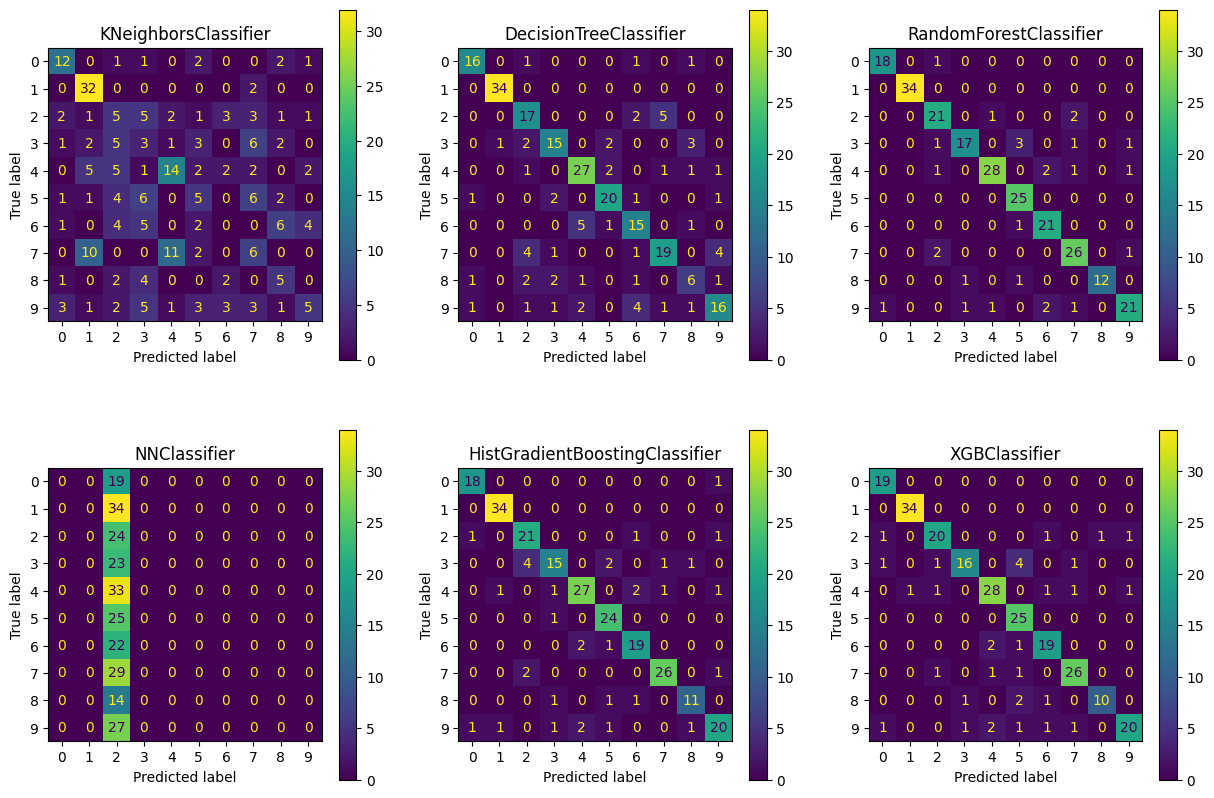

In [17]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels,
    nn_device = 'mps', nn_epochs = 100, nn_batch_size = 64
)

#### StandardScaler

In [18]:
import sklearn.preprocessing

standard_scaler = sklearn.preprocessing.StandardScaler()
train_features_scaled = standard_scaler.fit_transform(train_features)
test_features_scaled = standard_scaler.transform(test_features)

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x16c0eff10>


100%|██████████| 100/100 [00:15<00:00,  6.56it/s, loss=1.49e+3]


Fitting HistGradientBoostingClassifier(max_depth=4, max_iter=25, random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.740,0.836,0.916,0.940,0.960,0.968,0.976,0.992,1.000,0.940554,0.748695,0.735115,0.731402
1,DecisionTreeClassifier,0.760,0.808,0.844,0.868,0.896,0.928,0.952,0.988,0.988,0.854055,0.742579,0.737300,0.738403
2,RandomForestClassifier,0.888,0.944,0.956,0.968,0.976,0.988,1.000,1.000,1.000,0.982521,0.883408,0.885767,0.883398
3,NNClassifier,0.848,0.904,0.940,0.960,0.968,0.980,0.984,0.992,0.996,0.975143,0.834483,0.838122,0.832059
4,HistGradientBoostingClassifier,0.864,0.936,0.968,0.972,0.984,0.984,0.984,0.988,0.996,0.982114,0.860781,0.856415,0.856345
5,XGBClassifier,0.872,0.932,0.968,0.980,0.988,0.988,0.988,0.992,0.992,0.984723,0.874958,0.866411,0.866476


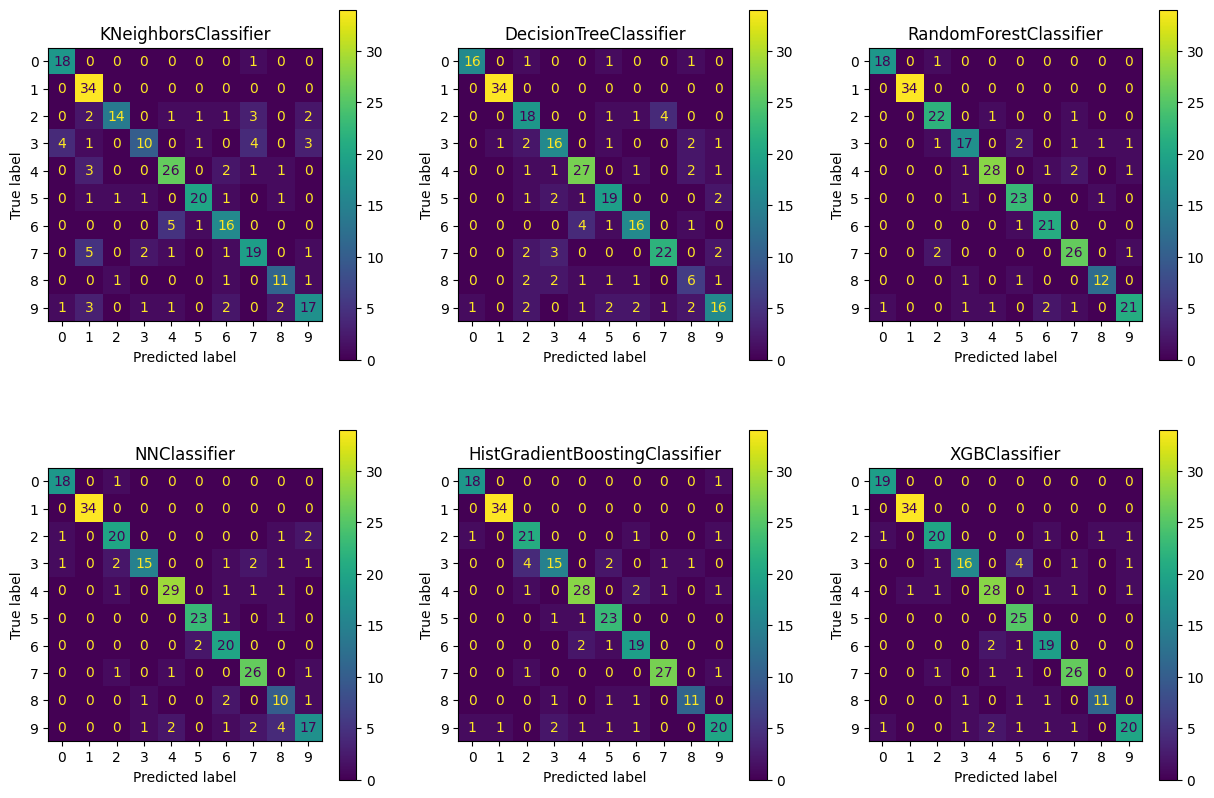

In [19]:
cvtda.classification.classify(
    train_features_scaled, train_labels, test_features_scaled, test_labels,
    nn_device = 'mps', nn_epochs = 100, nn_batch_size = 64
)

#### PCA

In [20]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 128, random_state = 42)

train_features_pca = pca.fit_transform(train_features_scaled)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])

test_features_pca = pca.transform(test_features_scaled)

Explained variance 0.98
[0.245, 0.206, 0.061, 0.055, 0.041, 0.035, 0.025, 0.019, 0.017, 0.015, 0.014, 0.013, 0.011, 0.01, 0.009, 0.009, 0.008, 0.007, 0.007, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x134ba96c0>


100%|██████████| 100/100 [00:11<00:00,  8.64it/s, loss=1.48e+3]


Fitting HistGradientBoostingClassifier(max_depth=4, max_iter=25, random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.748,0.840,0.924,0.936,0.952,0.964,0.976,0.992,1.000,0.940162,0.752498,0.743092,0.738881
1,DecisionTreeClassifier,0.636,0.672,0.720,0.764,0.812,0.856,0.916,0.968,0.972,0.784167,0.618184,0.611500,0.608812
2,RandomForestClassifier,0.812,0.908,0.928,0.944,0.956,0.964,0.980,0.988,0.996,0.959311,0.796817,0.796907,0.792967
3,NNClassifier,0.872,0.932,0.952,0.972,0.976,0.988,0.992,0.992,0.992,0.978110,0.855923,0.861021,0.856789
4,HistGradientBoostingClassifier,0.780,0.896,0.924,0.944,0.956,0.968,0.980,0.984,0.992,0.967689,0.774963,0.768240,0.764598
5,XGBClassifier,0.800,0.896,0.936,0.948,0.964,0.976,0.980,0.988,0.992,0.971770,0.786216,0.784709,0.780337


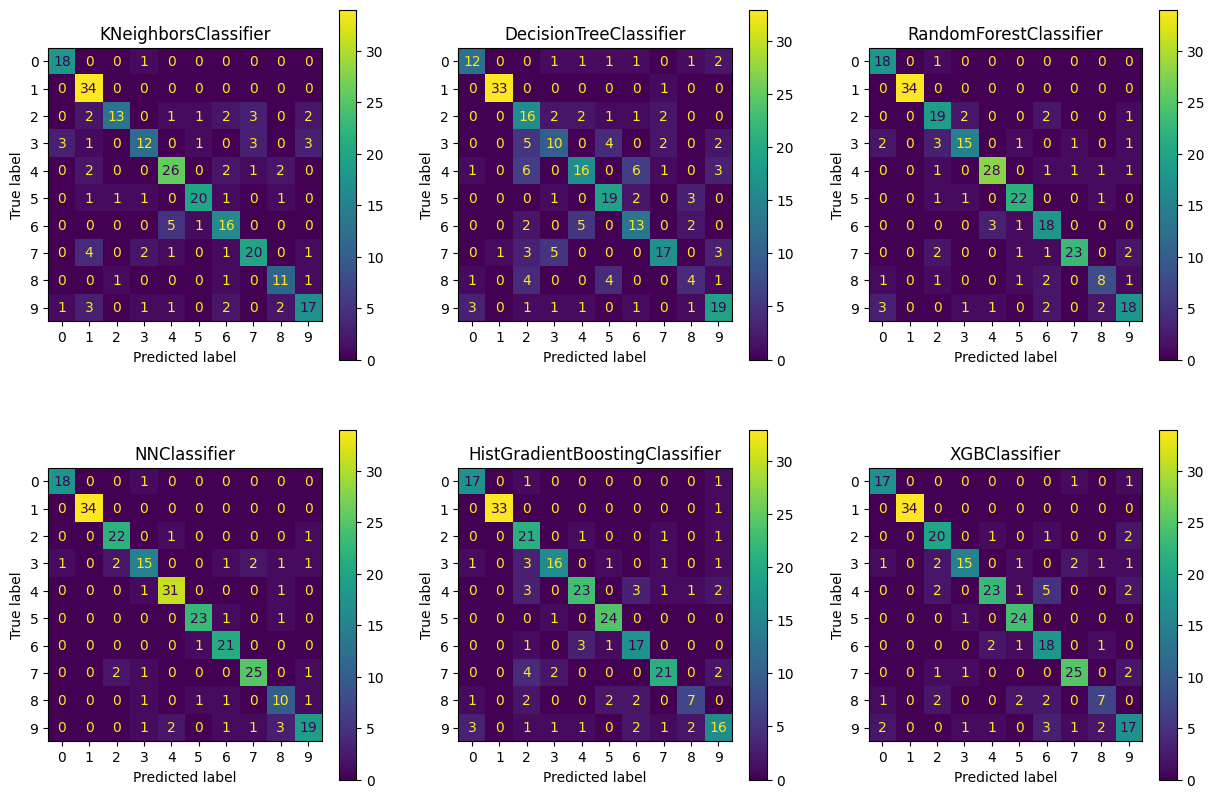

In [21]:
cvtda.classification.classify(
    train_features_pca, train_labels, test_features_pca, test_labels,
    nn_device = 'mps', nn_epochs = 100, nn_batch_size = 64
)

#### UMAP

In [22]:
import umap

umap_ = umap.UMAP(n_components = 128, n_jobs = -1)
train_features_umap = umap_.fit_transform(train_features)
test_features_umap = umap_.transform(test_features)

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x16c2ee7d0>


100%|██████████| 100/100 [00:11<00:00,  8.41it/s, loss=2.18e+3]


Fitting HistGradientBoostingClassifier(max_depth=4, max_iter=25, random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.296,0.484,0.584,0.712,0.764,0.812,0.872,0.948,0.976,0.701153,0.241960,0.273562,0.251617
1,DecisionTreeClassifier,0.260,0.360,0.388,0.488,0.592,0.696,0.776,0.892,0.952,0.589522,0.280119,0.261139,0.264869
2,RandomForestClassifier,0.268,0.452,0.572,0.700,0.788,0.856,0.920,0.960,0.992,0.720642,0.243219,0.251605,0.234884
3,NNClassifier,0.280,0.484,0.584,0.660,0.748,0.836,0.948,0.956,1.000,0.742027,0.156766,0.281744,0.195237
4,HistGradientBoostingClassifier,0.292,0.460,0.644,0.720,0.816,0.912,0.952,0.984,0.996,0.749514,0.258696,0.280063,0.251725
5,XGBClassifier,0.272,0.432,0.592,0.700,0.788,0.880,0.924,0.976,0.988,0.714280,0.263376,0.256402,0.247893


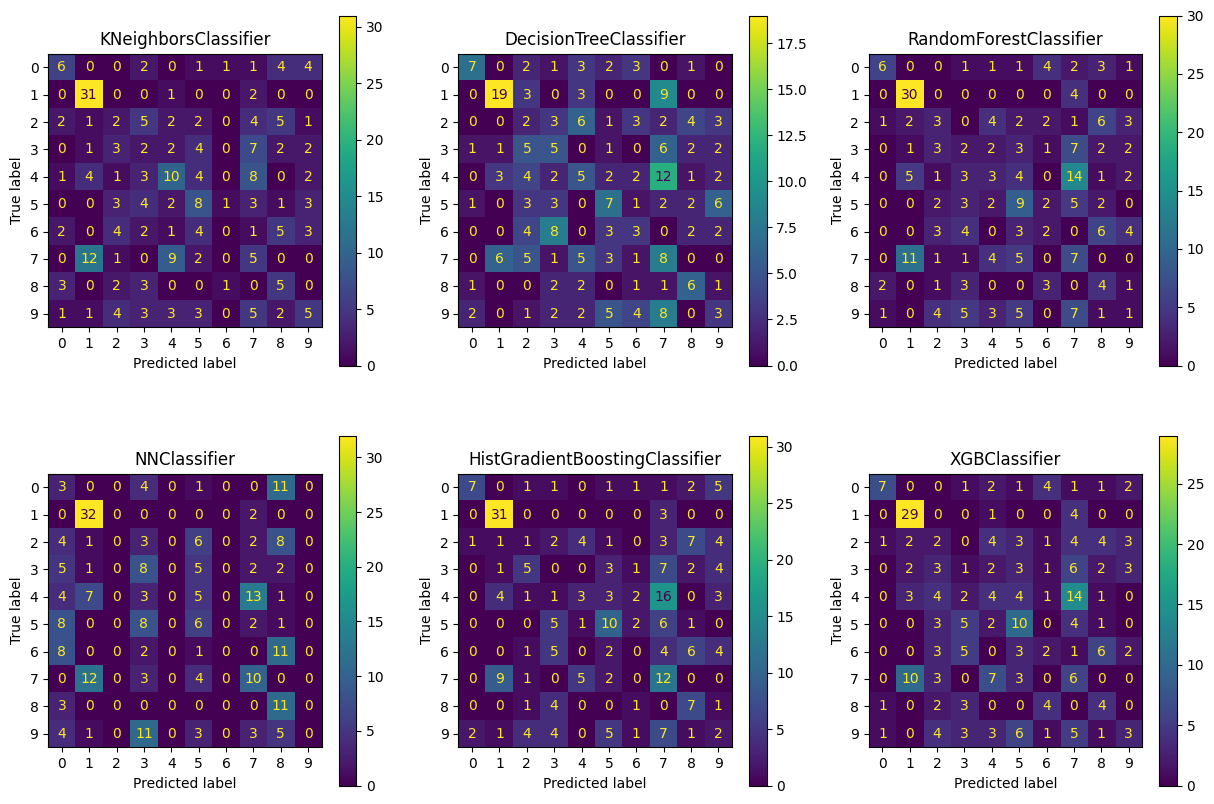

In [23]:
cvtda.classification.classify(
    train_features_umap, train_labels, test_features_umap, test_labels,
    nn_device = 'mps', nn_epochs = 100, nn_batch_size = 64
)